Some linear least squares fitting examples

First, let's define a function and get some random sample

<Container object of 3 artists>

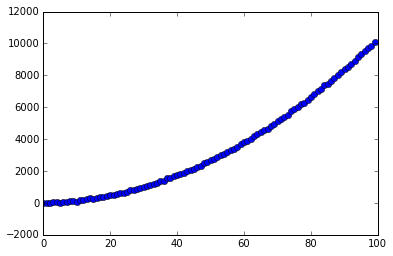

In [59]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import scipy

def func(x) :
    ''' A simple polynomial function '''
    a=5.6
    b=3.1
    return a + b*x + x**2

# get 100 samples with homoschedastic errors
n=100
sigma=25.5+np.zeros(100)
x=np.arange(n)
# get the y values with gaussian errors
y=func(x)+np.random.normal(0.,sigma,n)
# plot it up
plt.clf()
plt.errorbar(x,y,yerr=sigma,marker='o',linestyle='none')


In [60]:
# for a straight line fit, calculate the required sums
# short way
s=np.sum(1./sigma**2)
sx=np.sum(x/sigma**2)
sy=np.sum(y/sigma**2)
sxx=np.sum(x**2/sigma**2)
sxy=np.sum(x*y/sigma**2)
print s, sx, sy, sxx, sxy


0.153787004998 7.6124567474 529.501429946 504.959630911 39280.507644


-1605.76190629 101.996867768
chi2:  85135.7941048
probability:  1.0


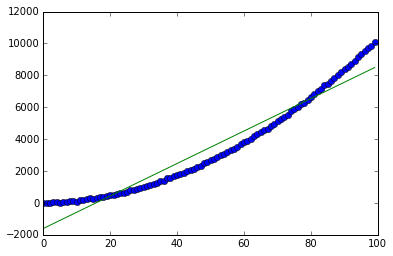

In [61]:

# now calculate the parameters
a = (sxx * sy - sx *sxy) / (s*sxx - sx**2)
b = (s * sxy - sx *sy) / (s*sxx - sx**2)

print a, b
plt.errorbar(x,y,yerr=sigma,marker='o',linestyle='none')
plt.plot(x,a+b*x)
plt.draw()

# calculate chi2
chi2=np.sum((y-(a+b*x))**2/sigma**2)
print 'chi2: ', chi2

df=n-2
from scipy import stats as stats
cdf=stats.chi2.cdf(chi2,df)
print 'probability: ', cdf



OK, now let's look at it with the general linear least squares formulation

In [62]:
def deriv(x) :
    # x should be numpy array, then we can return vectors of derivatives
    try :
        return [np.ones(len(x)),x]
    except :
        return [1.,x]

npar=2
alpha=np.zeros([npar,npar])
beta=np.zeros(npar)
for i in range(len(x)) :
    for k in np.arange(npar) :
        beta[k] += (deriv(x[i])[k]*y[i] /sigma[i]**2)
        for j in np.arange(npar) :
            alpha[k,j]+=(deriv(x[i])[k]*deriv(x[i])[j]/sigma[i]**2)
c=np.linalg.inv(alpha)
print np.dot(c,beta)


[-1605.76190629   101.99686777]


In [63]:
# note can do this more compactly with vector arithmetic
# loop over parameters, sums over data points are done with vector arithmetic
for k in np.arange(npar) :
    beta[k] = np.sum(deriv(x)[k]*y/sigma**2)
    for j in np.arange(npar) :
        alpha[k,j] = np.sum(deriv(x)[k]*deriv(x)[j]/sigma**2)
c=np.linalg.inv(alpha)
print np.dot(c,beta)

[-1605.76190629   101.99686777]


OK, now we'll just use the canned astropy routines


Model: Polynomial1D
Inputs: (u'x',)
Outputs: (u'y',)
Model set size: 1
Degree: 1
Parameters:
          c0             c1     
    -------------- -------------
    -1605.76190629 101.996867768
[-1605.76190629   101.99686777]


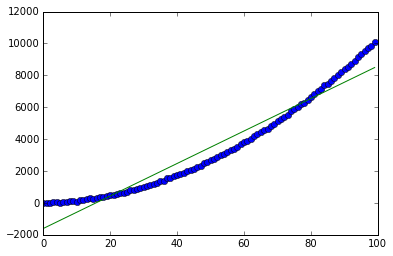

In [64]:
from astropy.modeling import models, fitting
fit_p = fitting.LinearLSQFitter()
p_init = models.Polynomial1D(degree=1)
pfit = fit_p(p_init,x,y)
print pfit
print pfit.parameters
# plot it up
plt.errorbar(x,y,yerr=sigma,marker='o',linestyle='none')
# pfit(x) evaluates the fit at locations x
plt.plot(x,pfit(x))
plt.draw()


OK, here's a nonlinear function

<Container object of 3 artists>

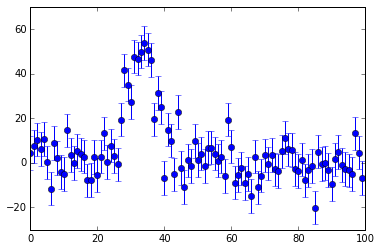

In [68]:

def func(x, a=50.6, b=33.1, c=4) :
    ''' A simple Gaussian function '''
    return a * np.exp(-0.5 * (x-b)**2/c**2)  

# get 100 samples with homoschedastic errors
n=100
sigma=7.5+np.zeros(100)
x=np.arange(n)
# get the y values with gaussian errors
y=func(x)+np.random.normal(0.,sigma,n)
# plot it up
plt.clf()
plt.errorbar(x,y,yerr=sigma,marker='o',linestyle='none')

Model: Gaussian1D
Inputs: (u'x',)
Outputs: (u'y',)
Model set size: 1
Parameters:
      amplitude        mean         stddev   
    ------------- ------------- -------------
    51.7511629168 33.0469282417 4.13064959908
[ 51.75116292  33.04692824   4.1306496 ]


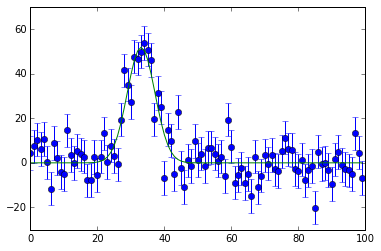

In [69]:
from astropy.modeling import models, fitting
fit_p = fitting.LevMarLSQFitter()
p_init = models.Gaussian1D(amplitude=60,mean=30,stddev=10)
pfit = fit_p(p_init,x,y)
print pfit
print pfit.parameters
# plot it up
plt.errorbar(x,y,yerr=sigma,marker='o',linestyle='none')
# pfit(x) evaluates the fit at locations x
plt.plot(x,pfit(x))
plt.draw()

OK, let's do a Monte Carlo to get distribution of uncertainties

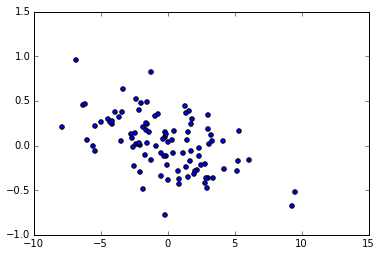

In [90]:
diff=[]
for sim in range(1000) :
    test=func(x,a=pfit.parameters[0],b=pfit.parameters[1],c=pfit.parameters[2])+np.random.normal(0.,sigma,n)
    simfit = fit_p(p_init,x,test)
    diff.append(simfit.parameters-pfit.parameters)
 
diff=np.array(diff)
diff.shape

plt.scatter(diff[:,0],diff[:,2])


locx: [-10.   -9.6  -9.2  -8.8  -8.4  -8.   -7.6  -7.2  -6.8  -6.4  -6.   -5.6
  -5.2  -4.8  -4.4  -4.   -3.6  -3.2  -2.8  -2.4  -2.   -1.6  -1.2  -0.8
  -0.4   0.    0.4   0.8   1.2   1.6   2.    2.4   2.8   3.2   3.6   4.
   4.4   4.8   5.2   5.6   6.    6.4   6.8   7.2   7.6   8.    8.4   8.8
   9.2   9.6  10. ]
locy: [-5.  -4.8 -4.6 -4.4 -4.2 -4.  -3.8 -3.6 -3.4 -3.2 -3.  -2.8 -2.6 -2.4 -2.2
 -2.  -1.8 -1.6 -1.4 -1.2 -1.  -0.8 -0.6 -0.4 -0.2  0.   0.2  0.4  0.6  0.8
  1.   1.2  1.4  1.6  1.8  2.   2.2  2.4  2.6  2.8  3.   3.2  3.4  3.6  3.8
  4.   4.2  4.4  4.6  4.8  5. ]
17.3159256328
2.54011258235


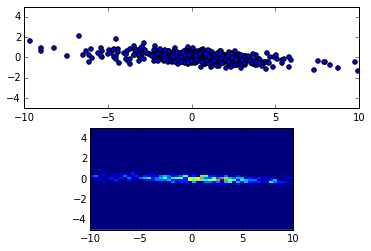

In [121]:
diff=[]
for sim in range(500) :
    resample_i = np.floor(np.random.rand(n)*len(x)).astype(int)
    x_resample = x[resample_i]
    y_resample = y[resample_i]
    simfit = fit_p(p_init,x_resample,y_resample)
    diff.append(simfit.parameters-pfit.parameters)
 
diff=np.array(diff)
diff.shape

plt.subplot(211)
plt.scatter(diff[:,0],diff[:,2])

#histogram definition
xmin=-10
xmax=10
ymin=-5
ymax=5
xyrange = [[xmin,xmax],[ymin,ymax]] # data range
bins = [50,50] # number of bins

plt.xlim([xmin,xmax])
plt.ylim([ymin,ymax])
# histogram the data
plt.subplot(212)
hh, locx, locy = scipy.histogram2d(diff[:,2], diff[:,0], range=xyrange, bins=bins)
plt.imshow(hh,interpolation='none',extent=(xmin,xmax,ymin,ymax),origin='lower')
print 'locx:',locx
print 'locy:',locy
print diff[:,0].max()
print diff[:,2].max()


In [67]:
def func(a,x,y,sigma) :
    ''' A simple Gaussian function 
    f=np.sum((y - (a[0] * np.exp(-0.5 * (x-a[1])**2/a[2]**2)))**2 / sigma**2 ) 
    return f
    
print x,y,sigma
from scipy import optimize
pars = optimize.fmin(func,x0=[50.,30.,10.],args=(x,y,sigma),retall=True)

print pars

SyntaxError: EOF while scanning triple-quoted string literal (<ipython-input-67-38afe651facf>, line 10)